In [1]:
import sys, os

#move into directory above ricepaper lib
os.chdir('../..')

In [2]:
#import ricepaper classes
from ricepaper import RicePaper

A simple model
----

Ricepaper provides a wrapper class for building simulations, writing them to a model definition file (trubalw.dat) and then  calling RiceBall to run the simulation. In the following we create a simple sandpile by gravity settling particles of two different radii.

In [3]:
#create ricepaper model
R = RicePaper("RicePaperTest")

We begin by defining the numerical properties of the model to default values, and the simulation timestep to 0.005 seconds. We also define gravitational acceleration. 

In [4]:
#numerical properties
R.setDamping(viscous_fraction=0.01) #1% of velocity is attenuated in each step. Helps model converge faster
R.setBounds(15000,10000,150)
tstep = 0.005
R.setNumericalProperties(timestep=tstep)
#R.nboxes = 1500
R.setGravity((0,-9.8,0)) #set gravity

The following then defines material properties for the different types of particles

In [5]:
#particle 1
R.setRadius(1,60)
R.setDensity(1,2500)
R.setHertzian(1,2.9e9,0.2)

#particle 2
R.setRadius(2,30) 
R.setDensity(2,2500)
R.setHertzian(2,2.9e9,0.2) #set elastic properties (shear modulus and poissons ratio)

#particle 3
R.setRadius(3,40)
R.setDensity(3,2500)
R.setHertzian(3,2.9e9,0.2)

#particle interactions
R.setLinItc(1,1,2e10,2e10)
R.setLinItc(1,2,2e10,2e10)
R.setLinItc(1,3,2e10,2e10)
R.setLinItc(2,2,2e10,2e10)
R.setLinItc(2,3,2e10,2e10)
R.setLinItc(3,3,2e10,2e10)
R.setFrictionItc(1,1,0.3)
R.setFrictionItc(1,2,0.3)
R.setFrictionItc(1,3,0.3)
R.setFrictionItc(2,2,0.3)
R.setFrictionItc(2,3,0.3)
R.setFrictionItc(3,3,0.3)

Next, we create lines of touching balls along the base and sides of our "model domain" to give particles something to land on (and stop them rolling off the sides). These balls are then pinned by fixing all degrees of freedom. 

In [6]:
R.genLine((100, 100, 25),(100, 2000, 25), 2.0, 3, 3) #left side
R.genLine((14900, 100, 25),(14900, 2000, 255), 2.0, 3, 3) #right side
R.genLine((200, 100, 25),(14800, 100, 25), 2.0, 3, 3) #base side
R.fixDOFAll(True,True,True) #fix DOF on balls to keep them in place

Finally, we define an area to randomly generate new balls within (slightly above the model base so they can settle gravitationally) and create four batches of balls, each separated by 2000 timesteps to give them time to settle. Finally everything is run for another 5000 timesteps such that we (hopefully!) reach equillibrium...

In [7]:
#generate some balls!
R.setDomain(6000,9000,6000,8000,0,100) #domain to create balls in

#create balls and cycle
steps = [] #keep a list of steps (output files at each cycle command)
for i in range(4):
    R.genBalls(100,1,1,color=2) #create 100 balls with 60 m radius
    R.genBalls(100,2,1,color=3) #create 100 balls with 50 m radius
    steps.append(R.cycle(5*60)) #run 5 mins of model time

#cycle to equillibrium    
for i in range(10):
    steps.append(R.cycle(10*60)) #run another 5 mins of model time

Now that the model is defined, RicePaper can write the model definition file and pass it to RiceBall for execution.

In [8]:
success = R.execute(suppress=False)

'RicePaperTest' finished in 13.70 minutes.


Reading the output
---------

Assuming that riceball could be found and executed succesfully, a folder called "RicePaperTest" should have been created in *rundir* and a bunch of files created there. The *trubalw.dat* file contains the model definition passed to RiceBall (essentially what we created above), while the *trubalw.out* file contains any output (and errors) from RiceBall. a serires of *.OUT* files should also have been created, containing the location of particles after each set of cycles had finished and the forces resulting from interactions between them.

RicePaper can read this output and, using networkX and matplotlib, we can quickly visualise them to see if everything worked!

/home/user1/Documents/notebooks/riceball/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


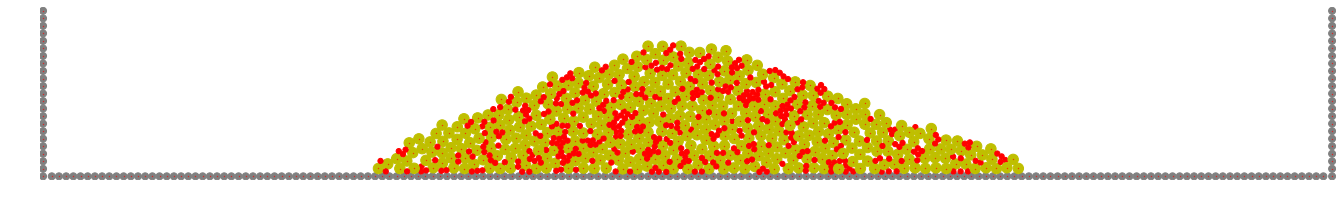

In [9]:
model = R.loadLastOutput() #load the output from the final cycle command (i.e. once everything is finished)
model.quickPlot()

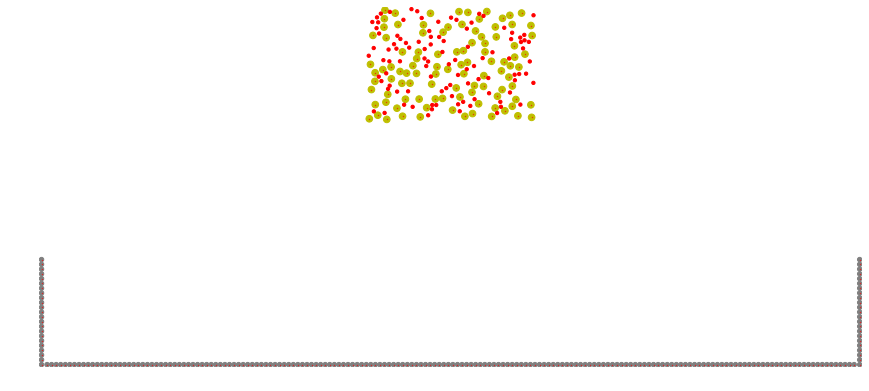

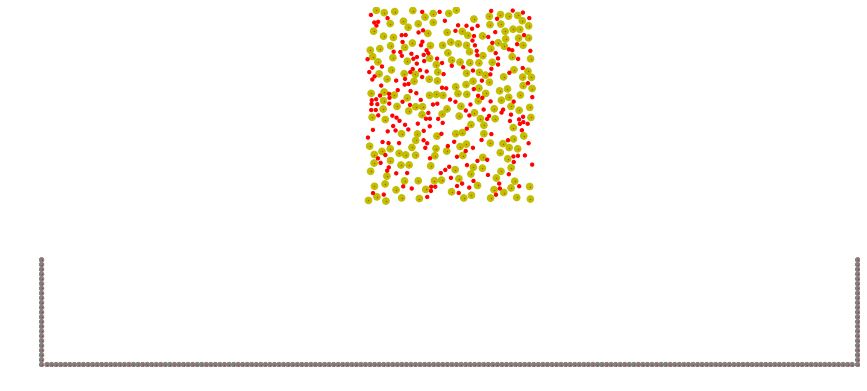

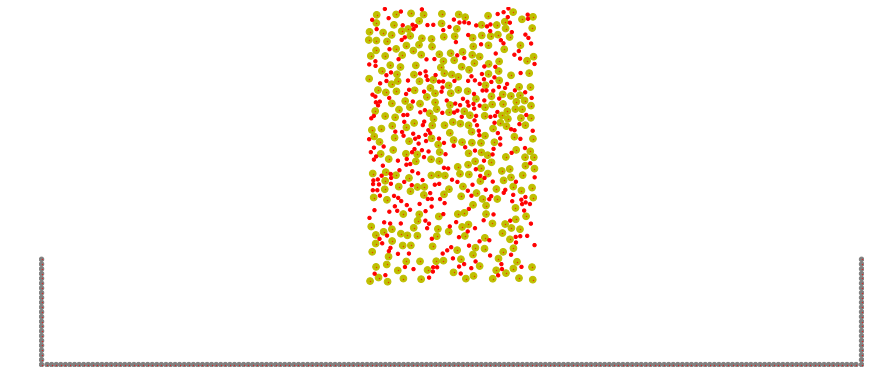

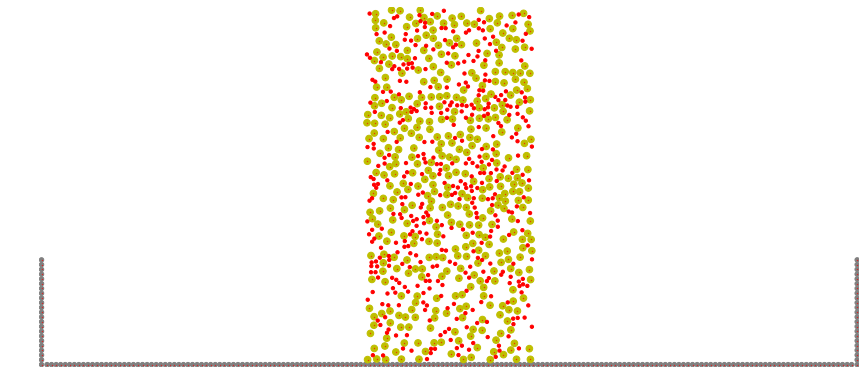

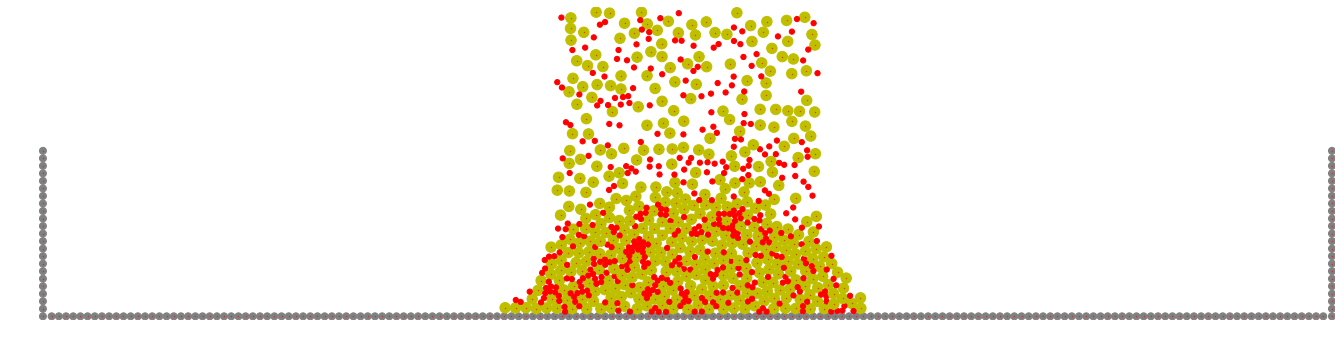

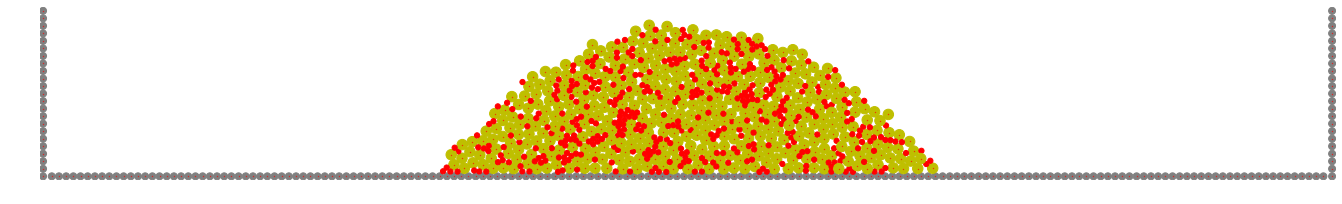

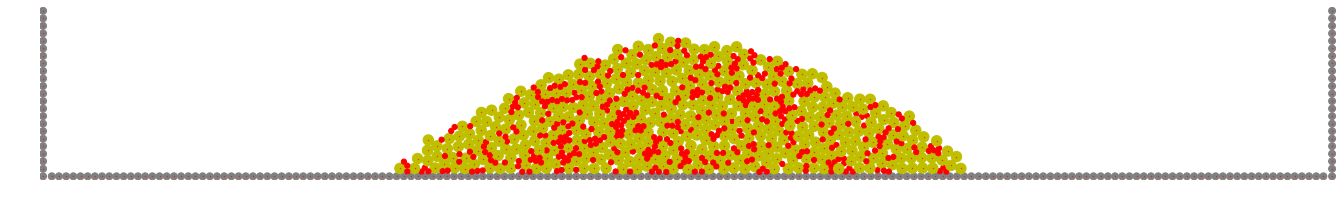

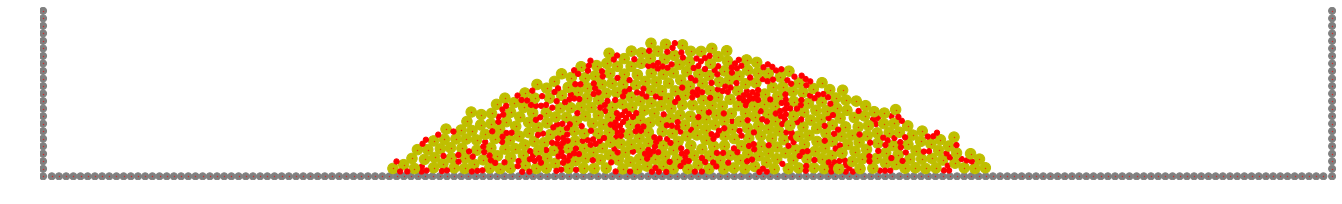

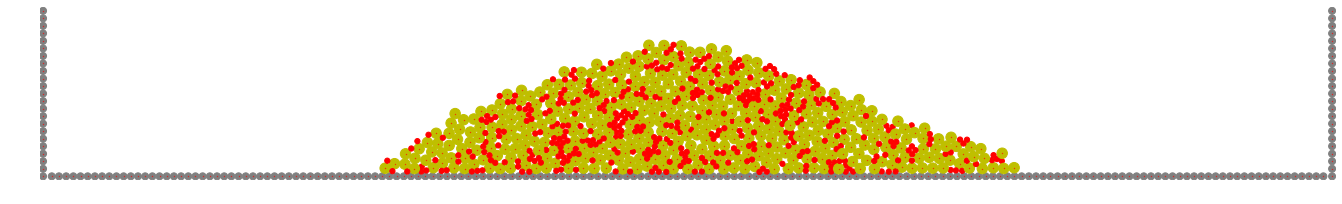

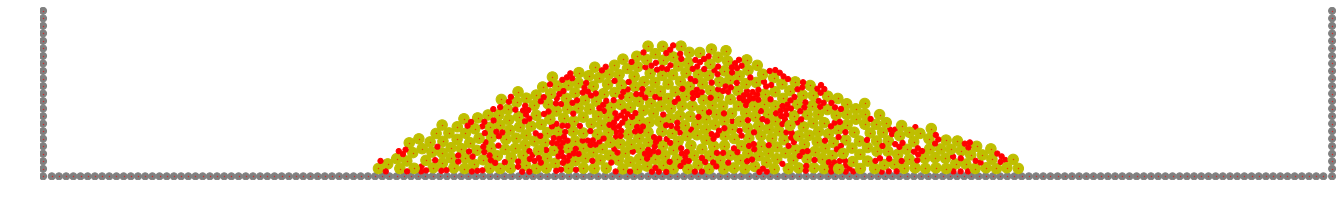

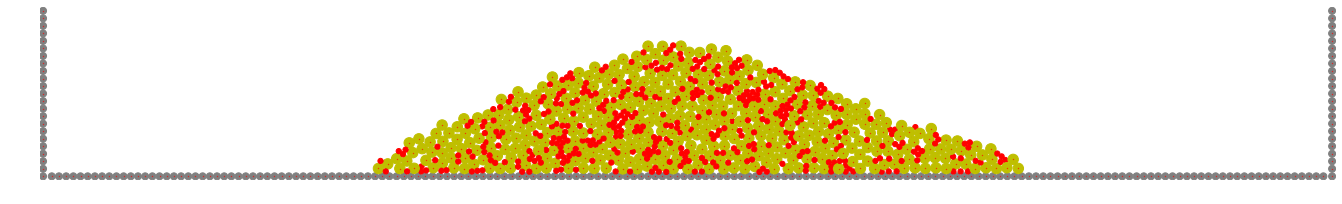

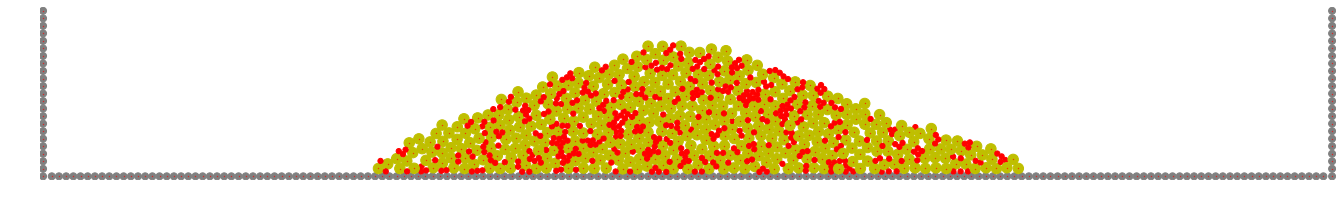

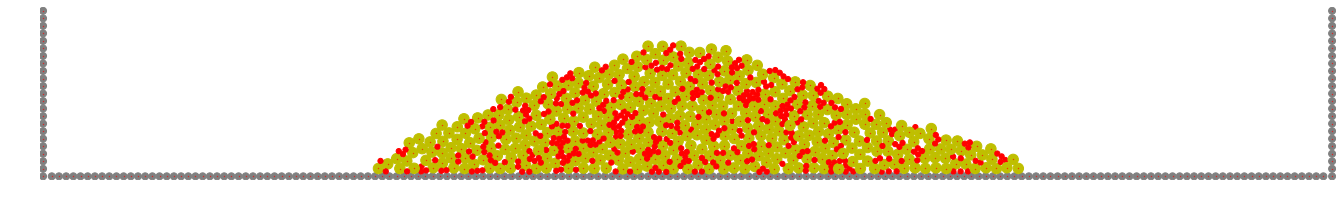

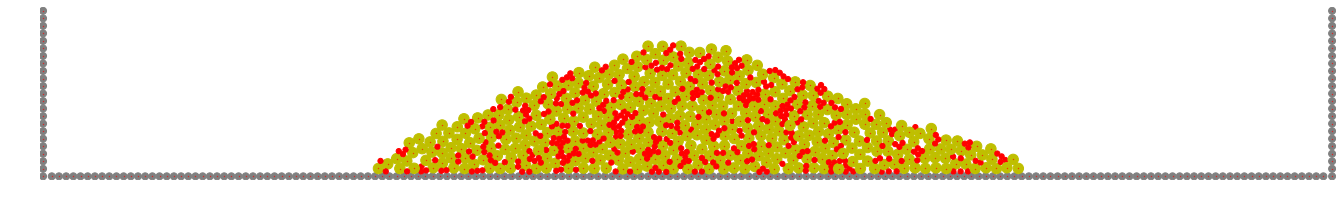

In [10]:
#and plot a sequence
M = R.loadSteps(steps)
for m in M:
    m.quickPlot()

Finally, we plot the kinetic energy and velocity of the particles to check that the system has reached a static equillibrium: 

/home/user1/Documents/notebooks/riceball/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


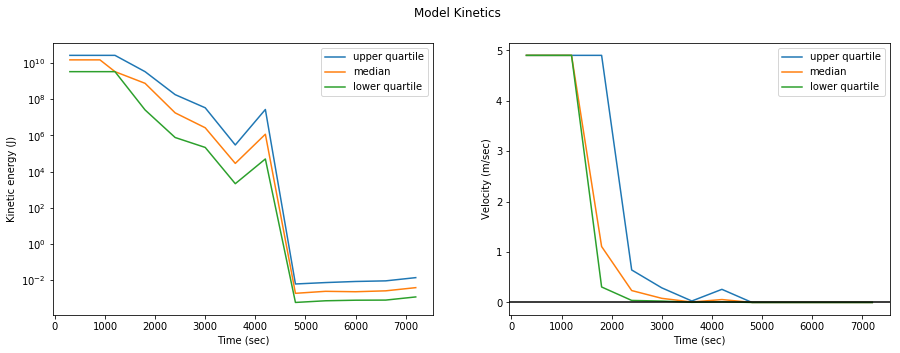

In [11]:
fig,ax = R.plotKinetics(steps)